In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
import sys

sys.path.insert(0, '/home/aew492/research-summer2020/code')
from suave import cf_model

In [2]:
# scipy.optimize.minimize(function, x0, method=None, jac=None, bounds=None): (other optional args; see docs.)
#   takes in a function to minimize: we will pass chi-squared
#   takes the jacobian as an optional arg: see below
#   ALSO importantly takes parameter bounds as an optional arg: we will constrain B_sq > 0
#   we'll use method='L-BFGS-B'

# x = params = [ B_sq, a1, a2, a3]   shape (4,1)
# y = L-S results   shape (22,)
# A = feature matrix (including xi_mod)   shape (22,4)
# C = covariance matrix   shape (22,22)

# resid = y - A@x = (22,) - (22,4)(4,1) = (22,)
# resid @ (Cinv@resid) = (22,) @ (22,22)(22,) = (22,)(22,) ?? ==> (1,22)(22,) = (1,)

# resid = (22,)
# -2*A.T @ (Cinv@resid) = (4,22) @ (22,22)(22,) = (4,22)(22,) = (4,)

#   def chisq(x, A, y, Cinv)
#     resid = y-A@x
#     return resid @ (Cinv @ resid)

# Jacobian
#   def jacobian(x, A, y, Cinv)
#     resid = y-A@x
#     return -2*A.T@(Cinv @ resid)

In [3]:
def chisq(x, A, y, Cinv):
    resid = y - A@x
    return resid @ (Cinv @ resid)

In [4]:
def jacobian(x, A, y, Cinv):
    resid = y - A@x
    return -2*A.T @ (Cinv @ resid)  # essentially returns the derivative of chi-squared

### test: lognormal

In [5]:
rlz = 0
cat_tag = 'L750_n1e-4_z057_patchy_As2x'
alpha = 1.0

In [6]:
# other parameters
cosmo_base = None
redshift = 0.57
bias = 2.0

In [7]:
# load in values
data_dir = '/scratch/aew492/research-summer2020_output/'

# y = L-S results
xi_ls = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_lognormal.npy'))
r_avg = xi_ls[0]
y = xi_ls[1]
nbins = len(r_avg)

In [8]:
# A = feature matrix
xi_mod = cf_model(alpha*r_avg, cosmo_base=cosmo_base, redshift=redshift, bias=bias)
A = np.array([xi_mod, 1/r_avg**2, 1/r_avg, np.ones(nbins)]).T
A.shape

(22, 4)

In [9]:
# covariance matrix
nmocks = 401
xi_lss = np.empty((nmocks, nbins))

for rlz in range(nmocks):
    xi_ls = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
    xi_lss[rlz] = xi_ls[1]
    
cov_full = np.cov(xi_lss.T)
Cinv = np.linalg.inv(cov_full)   # !!! change this! so that we don't have to use Cinv; this function is too unstable

In [10]:
# other parameters for minimize function
x0 = np.ones(4)   #[2,0,0,0]   # initial parameters guess

bnds = ((0, None), (None, None), (None, None), (None, None))   # bounds for parameters (B_sq > 0)

### scipy.optimize.minimize

In [11]:
# we don't actually calculate chi-squared or the jacobian ourselves; instead, we pass these functions to scipy.minimize
minimize = scipy.optimize.minimize(chisq, x0, args=(A,y,Cinv), method='L-BFGS-B', jac=jacobian, bounds=bnds)

In [12]:
minimize

      fun: 23.623668700485844
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.51274411e-04, 1.52516153e-06, 3.94408164e-05, 4.99866194e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 48
     njev: 57
   status: 0
  success: True
        x: array([ 2.27476994e+00, -4.71953282e+01,  7.25191400e-01, -2.31699545e-03])

## function it

In [13]:
def minimize_chisq(rlz, cov, extra_info=False, cat_tag='L750_n1e-4_z057_patchy_As2x', data_dir='/scratch/aew492/research-summer2020_output/',
                   alpha=1.0, cosmo_base=None, redshift=0.57, bias=2.0):
    # y = L-S results
    xi_ls = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_lognormal.npy'))
    r_avg = xi_ls[0]
    y = xi_ls[1]
    nbins = len(r_avg)
    
    # A = feature matrix
    xi_mod = cf_model(alpha*r_avg, cosmo_base=cosmo_base, redshift=redshift, bias=bias)
    A = np.array([xi_mod, 1/r_avg**2, 1/r_avg, np.ones(nbins)]).T
    
    # covariance
    Cinv = np.linalg.inv(cov)
    
    # other parameters for minimize function
    x0 = np.ones(4)   # initial parameters guess
    jacob = jacobian(x0, A, y, Cinv)   # jacobian matrix
    bnds = ((0, None), (None, None), (None, None), (None, None))   # bounds for parameters (B_sq > 0)
    
    params = scipy.optimize.minimize(chisq, x0, args=(A,y,Cinv), method='L-BFGS-B', jac=jacobian, bounds=bnds)
    
    return params if extra_info else params['x']

In [14]:
nmocks = 401
params = np.empty((nmocks,4))
for rlz in range(nmocks):
    x = minimize_chisq(rlz, cov_full)
    params[rlz] = x

Text(0, 0.5, '# mocks')

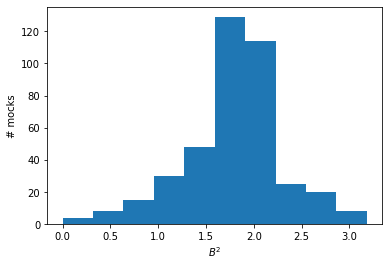

In [15]:
plt.hist(params[:,0])
plt.xlabel(r'$B^2$')
plt.ylabel('# mocks')

Text(0.5, 0.98, 'Distribution of parameters, 401 lognormal mocks, L750_n1e-4_z057_patchy_As2x: $\\alpha = 1.0$')

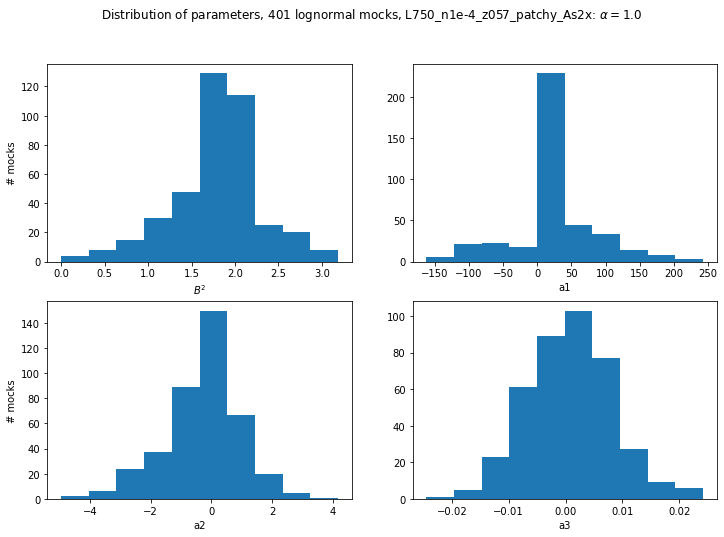

In [16]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
axs[0,0].hist(params[:,0])
axs[0,0].set_xlabel(r'$B^2$')
axs[0,0].set_ylabel('# mocks')
axs[0,1].hist(params[:,1])
axs[0,1].set_xlabel('a1')

axs[1,0].hist(params[:,2])
axs[1,0].set_xlabel('a2')
axs[1,0].set_ylabel('# mocks')
axs[1,1].hist(params[:,3])
axs[1,1].set_xlabel('a3')

fig.suptitle(fr'Distribution of parameters, 401 lognormal mocks, {cat_tag}: $\alpha = 1.0$')

## loaded data

In [24]:
nmocks = 401
params = np.empty((nmocks,4))
for rlz in range(nmocks):
    data = np.load(os.path.join(data_dir, f'bases/4-parameter_fit/scipy/results_lognormal_{cat_tag}/basis_lognormal_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True).item()
    params[rlz] = data['B_sq'], data['a1'], data['a2'], data['a3']

Text(0.5, 0.98, 'Distribution of parameters, 401 lognormal mocks, L750_n1e-4_z057_patchy_As2x')

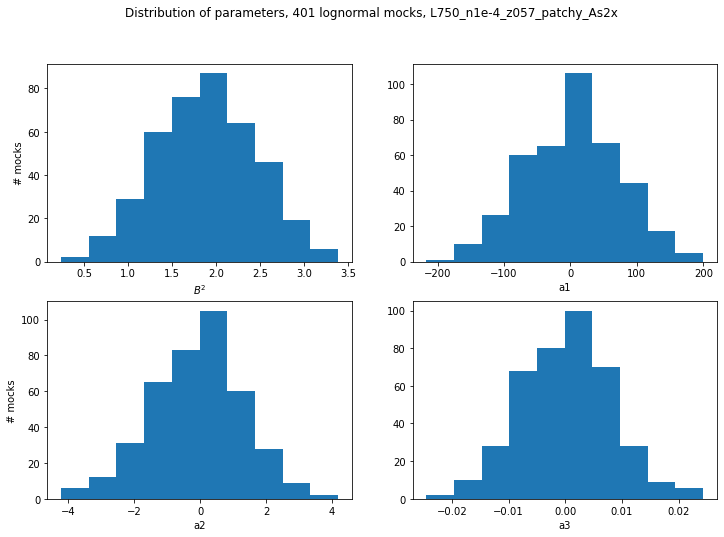

In [27]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
axs[0,0].hist(params[:,0])
axs[0,0].set_xlabel(r'$B^2$')
axs[0,0].set_ylabel('# mocks')
axs[0,1].hist(params[:,1])
axs[0,1].set_xlabel('a1')

axs[1,0].hist(params[:,2])
axs[1,0].set_xlabel('a2')
axs[1,0].set_ylabel('# mocks')
axs[1,1].hist(params[:,3])
axs[1,1].set_xlabel('a3')

fig.suptitle(fr'Distribution of parameters, 401 lognormal mocks, {cat_tag}')

### distribution of alphas

In [29]:
old_fit_alphas = np.ones(nmocks)
bao_alphas = np.ones(nmocks)
new_fit_alphas = np.ones(nmocks)

for rlz in range(nmocks):
    # old 4-parameter fit results, with full covariance matrix
    fit_results = np.load(os.path.join(data_dir, f'bases/4-parameter_fit/full/results_lognormal_{cat_tag}/basis_lognormal_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True).item()
    B_sq_old = fit_results['B_sq']
    a1_old = fit_results['a1']
    a2_old = fit_results['a2']
    a3_old = fit_results['a3']
    old_fit_alpha = fit_results['best_alpha']
    
    # bao iterative results
    bao_results = np.load(os.path.join(data_dir, f'bases/bao_iterative/results/results_lognormal_{cat_tag}/converged/cf_baoiter_cosmoplanck15_test_trrnum_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
    rcont, bao_basis, _, _, extra_dict = bao_results
    bao_alpha = extra_dict['alpha_model']
    
    # new scipy fit
    scipy_results = np.load(os.path.join(data_dir, f'bases/4-parameter_fit/scipy/results_lognormal_{cat_tag}/basis_lognormal_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True).item()
    B_sq_new = scipy_results['B_sq']
    a1_new = scipy_results['a1']
    a2_new = scipy_results['a2']
    a3_new = scipy_results['a3']
    new_fit_alpha = scipy_results['best_alpha']
    
    old_fit_alphas[rlz] = old_fit_alpha
    bao_alphas[rlz] = bao_alpha
    new_fit_alphas[rlz] = new_fit_alpha

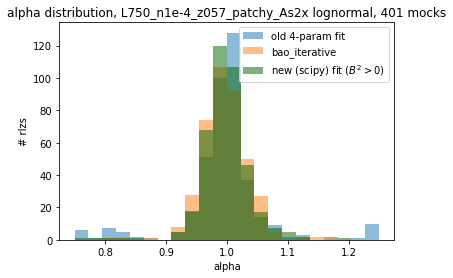

In [33]:
alpha = 0.5

fig, ax = plt.subplots()

_, bins, _ = ax.hist(old_fit_alphas, bins=nbins, alpha=alpha, label='old 4-param fit')
ax.hist(bao_alphas, bins=bins, alpha=alpha, label='bao_iterative')
ax.hist(new_fit_alphas, bins=bins, alpha=alpha, color='darkgreen', label=f'new (scipy) fit ($B^2 > 0$)')
ax.set_title(f'alpha distribution, {cat_tag} lognormal, 401 mocks')
ax.set_xlabel('alpha')
ax.set_ylabel('# rlzs')
plt.legend()